This notebook was derived from https://github.com/DDS-Lab/disaster-image-processing.

Because many areas captured by satellite images have extensive cloud cover, we want to remove them from our dataset entirely as they don't include any actual images of buildings. Using simple colorhistogram operations, we detect cloudy images and images with substantial black regions.

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio
import sklearn as sk

from sklearn.decomposition import NMF

%matplotlib inline

TILE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/post_event'

To create a simple measure of how much "whiteness" is in the image, we can first calculate a grayscale image by averaging the channels of the RGB image. Then we can calculate the histogram of the greyscale image. The advantage of this approach is that it uses the distribution of the intensity values and it works for comparing images of different size.

## Filter Digital Globe tiles

In [9]:
# Calculate the histogram for each crop and store it in a tuple list to later dump into a pandas DataFrame.
h_list = {}
img_counter = 0
for curr_dir, _, file_list in os.walk(TILE_DIR):
    for file in file_list:
        # Do not include pyramids, which are stored in a /1 dir with in the tiles/ directory.
        if curr_dir.endswith('1') or not file.endswith(".tif"):
            continue
        with rasterio.open(curr_dir + "/" + file, 'r') as r:
            arr = r.read()
        
        h, bins = np.histogram(arr[:,:,:].mean(axis=2), bins=100, density=True, range=[0,255])
        h_list[curr_dir + "/" + file] = h
        
        img_counter += 1
        if img_counter % 1000 == 0:
            print("Processed {0} crop images, current img: {1}".format(img_counter, file))
        
print("Finished processing {} histograms".format(img_counter))

Processed 1000 crop images, current img: 2020131__jpeg_compressed_05_01.tif
Processed 2000 crop images, current img: 2002332_3_jpeg_compressed_02_10.tif
Processed 3000 crop images, current img: 2020101_3_jpeg_compressed_08_02.tif
Processed 4000 crop images, current img: 2021000_jpeg_compressed_01_03.tif
Processed 5000 crop images, current img: 2020113_2_jpeg_compressed_04_02.tif
Processed 6000 crop images, current img: 2002332_2_jpeg_compressed_06_01.tif
Processed 7000 crop images, current img: 2030030_jpeg_compressed_10_02.tif
Processed 8000 crop images, current img: 2021112_jpeg_compressed_08_01.tif
Processed 9000 crop images, current img: 2003330_jpeg_compressed_06_03.tif
Processed 10000 crop images, current img: 2003210_jpeg_compressed_10_09.tif
Processed 11000 crop images, current img: 2003210_jpeg_compressed_10_02.tif
Processed 12000 crop images, current img: 2021101_jpeg_compressed_08_07.tif
Processed 13000 crop images, current img: 2003332_jpeg_compressed_03_02.tif
Processed 14

In [10]:
# Save histogram (just in case)
actual_h_list = []
for fname, hist in h_list.items():
    actual_h_list.append((fname, hist))

save_df_cols = list(map(list, zip(*actual_h_list)))
save_df = pd.DataFrame({'fname': save_df_cols[0], 
                        'hist': save_df_cols[1]})
save_df.to_csv(TILE_DIR + 'hist.csv')

#### Dimensionality Reduction of Histograms
We believe that files which have clouds will have a distribution shifted to the right (or if only part of them is covered by clouds, maybe they have a bump to the left and a second mode where most common values are). The histograms can be thought as features of the images and we can perform dimensionality reduction of those feature to detect common patterns. One of the most popular methods for dimensionsionality reduction is PCA, but that method is better suitable for data which is Gaussian distributed. Histograms have some constraints which need to be satisfied: they are always positive with values between 0 and 1. Instead of PCA we can use Nonnegative Matrix Factorization (NMF), which is also provided through the `sklearn.decomposition` package.

In [12]:
hist_df = pd.DataFrame(h_list)
pca = NMF(n_components=5)
pca.fit(hist_df.T)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=5, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

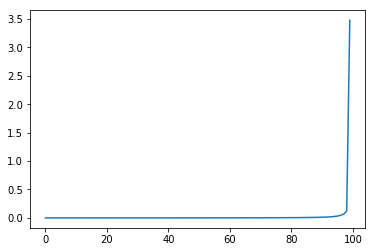

In [13]:
X_transformed = pca.transform(hist_df.T)
plt.plot(pca.components_[0,:])

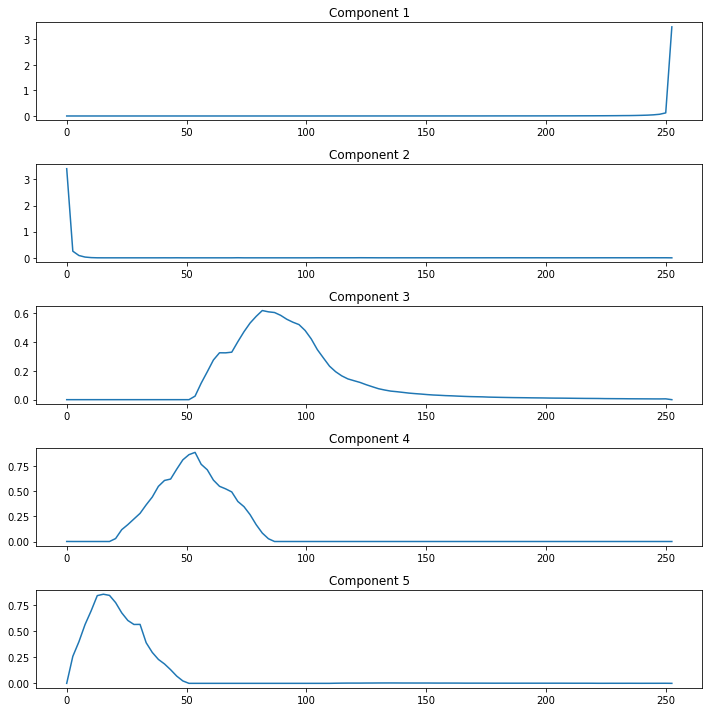

In [14]:
# Visualize the components
plt.figure(figsize = (10,10))
ax1 = plt.subplot(5, 1, 1)
for i in range(5):
    plt.subplot(5, 1, i+1, sharex=ax1)
    plt.plot(bins[:-1],pca.components_[i,:])
    plt.title('Component '+str(i+1))
plt.tight_layout()

We observe that second component has a peak around zero (black images), and component 1 has a peak around 255 (mostly white images). Let's order the images by their coefficient corresponding to the 5th component (here we have the advantage of all coefficients being positive: the larger the coefficient the larger the contribution).

In [24]:
# Create an index of decreasing 1st component coefficient, starting from 'all white' images
# decreasing to regular-color images.
white_idx = X_transformed[:,0].argsort()[::-1]
print(white_idx)

[15399 12914 20170 ... 11816 11815     0]


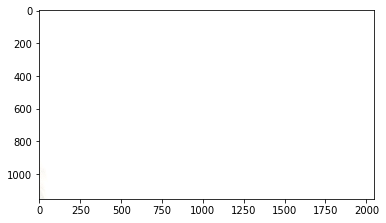

In [25]:
# Make sure topmost image is white
with rasterio.open(hist_df.columns[white_idx[0]], 'r') as r:
    arr = r.read()
      
plt.imshow(np.rollaxis(arr,0,3))


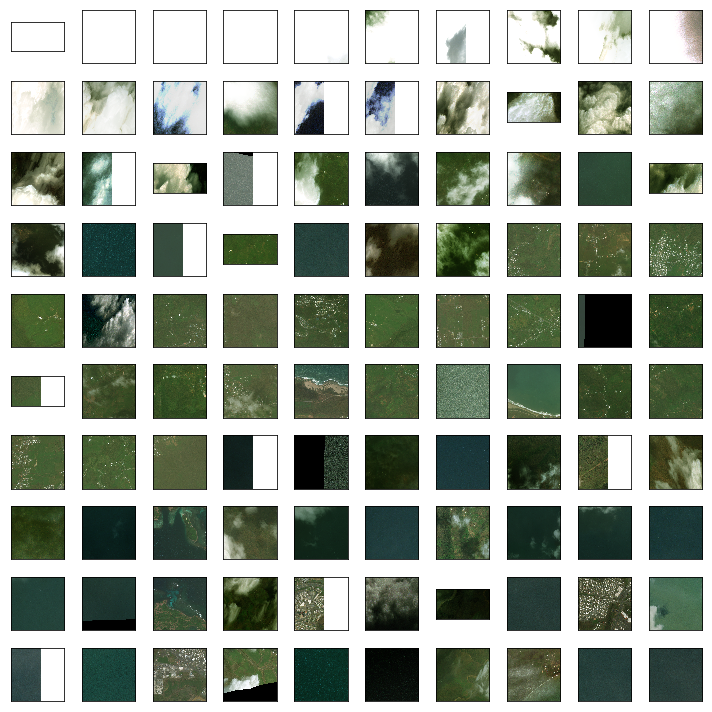

In [27]:
# Visualize the images in order of their "whiteness"
# order: left-to-right, row first
# skip - skips showing every skip'th image
# N - total number of images shown

plt.figure(figsize = (10,10))
#N = hist_df.shape[1]
N = 20000
skip = 200
m = math.floor(math.sqrt(N/skip))
ax1 = plt.subplot(m, m, 1)
for i,j in enumerate(range(0,N,skip)):
    plt.subplot(m, m, i+1, sharex=ax1)
    with rasterio.open(hist_df.columns[white_idx[j]], 'r') as r:
        arr = r.read()
    plt.imshow(np.rollaxis(arr,0,3))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

In [28]:
# Ceate an index of decreasing 3rd component coefficient, starting from 'all black' images
# decreasing to regular-color images.
black_idx = X_transformed[:,1].argsort()[::-1]
print(black_idx)

[17541 19187    37 ... 11590 11588     0]


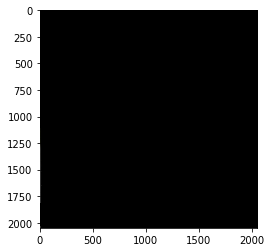

In [30]:
# Make sure topmost image is black
with rasterio.open(hist_df.columns[black_idx[0]], 'r') as r:
    arr = r.read()
      
plt.imshow(np.rollaxis(arr,0,3))

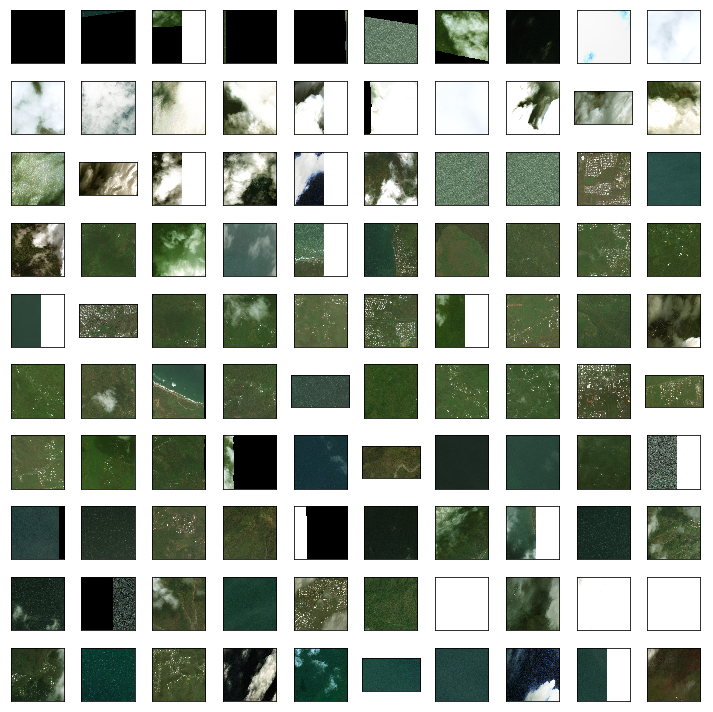

In [31]:
# Visualize the images in order of their "darkness"
# order: left-to-right, row first
# skip - skips showing every skip'th image
# N - total number of images shown

import math
plt.figure(figsize = (10,10))
N = hist_df.shape[1]
N = 20000
skip = 200
m = math.floor(math.sqrt(N/skip))
ax1 = plt.subplot(m, m, 1)
for i,j in enumerate(range(0,N,skip)):
    plt.subplot(m, m, i+1, sharex=ax1)
    with rasterio.open(hist_df.columns[black_idx[j]], 'r') as r:
        arr = r.read()
    plt.imshow(np.rollaxis(arr,0,3))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

In [34]:
# Store the filenames order by their "whiteness", up until images are no longer visibly all white.
# Move them out of our dataset.
WHITE_IDX_THRESH = 7400
OUT_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/bad_images/tiles/'

idx_count = 0
with open(OUT_DIR + 'white_img_list.txt', 'w') as f:
    for item in hist_df.columns[white_idx]:
        if idx_count == WHITE_IDX_THRESH:
            break
        f.write("%s\n" % item)
        
        os.system("mv {0} {1}".format(item, OUT_DIR + str(idx_count)))
        
        idx_count += 1

In [50]:
# Store the filenames order by their "blackness", up until images are no longer visibly all black.
# Move them out of our dataset.
BLACK_IDX_THRESH = 5800
OUT_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/bad_images/black/'

idx_count = 0
with open(BASE_DIR + 'black_img_list.txt', 'w') as f:
    for item in hist_df.columns[black_idx]:
        if idx_count == BLACK_IDX_THRESH:
            break
        f.write("%s\n" % item)
        
        os.system("mv {0} {1}".format(CROP_IMG_DIR + item, OUT_DIR + item))
        
        idx_count += 1

## Filter NOAA tiles

In [36]:
NOAA_TILE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/post_event/noaa/tiles'

# Calculate the histogram for each crop and store it in a tuple list to later dump into a pandas DataFrame.
h_list = {}
img_counter = 0
for curr_dir, _, file_list in os.walk(NOAA_TILE_DIR):
    for file in file_list:
        # Do not include pyramids, which are stored in a /1 dir with in the tiles/ directory.
        if curr_dir.endswith('1') or not file.endswith(".tif"):
            continue
        with rasterio.open(curr_dir + "/" + file, 'r') as r:
            arr = r.read()
        
        h, bins = np.histogram(arr[:,:,:].mean(axis=2), bins=100, density=True, range=[0,255])
        h_list[curr_dir + "/" + file] = h
        
        img_counter += 1
        if img_counter % 1000 == 0:
            print("Processed {0} crop images, current img: {1}".format(img_counter, file))
        
print("Finished processing {} histograms".format(img_counter))

Processed 1000 crop images, current img: 20170924bC0663430w183000n_11_17.tif
Processed 2000 crop images, current img: 20170924bC0660130w182700n_13_17.tif
Processed 3000 crop images, current img: 20170926bC0653130w180730n_14_18.tif
Processed 4000 crop images, current img: 20170926aC0664330w180000n_03_08.tif
Processed 5000 crop images, current img: 20170924aC0654930w180600n_13_18.tif
Processed 6000 crop images, current img: 20170926aC0661930w180000n_10_15.tif
Processed 7000 crop images, current img: 20170926aC0663430w180130n_01_12.tif
Processed 8000 crop images, current img: 20170924aC0652830w180900n_10_05.tif
Processed 9000 crop images, current img: 20170924bC0662100w183000n_09_16.tif
Processed 10000 crop images, current img: 20170924bC0662530w182830n_12_08.tif
Processed 11000 crop images, current img: 20170925aC0653730w182230n_06_08.tif
Processed 12000 crop images, current img: 20170924bC0655100w182530n_11_02.tif
Processed 13000 crop images, current img: 20170926aC0660900w175830n_14_13

In [37]:
# Save histogram (just in case)
actual_h_list = []
for fname, hist in h_list.items():
    actual_h_list.append((fname, hist))

save_df_cols = list(map(list, zip(*actual_h_list)))
save_df = pd.DataFrame({'fname': save_df_cols[0], 
                        'hist': save_df_cols[1]})
save_df.to_csv(NOAA_TILE_DIR + 'hist.csv')

In [38]:
hist_df = pd.DataFrame(h_list)
pca = NMF(n_components=5)
pca.fit(hist_df.T)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=5, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

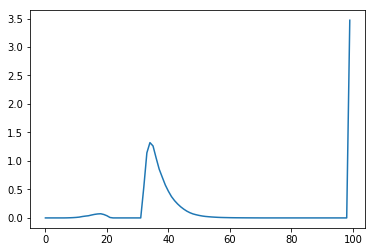

In [39]:
X_transformed = pca.transform(hist_df.T)
plt.plot(pca.components_[0,:])

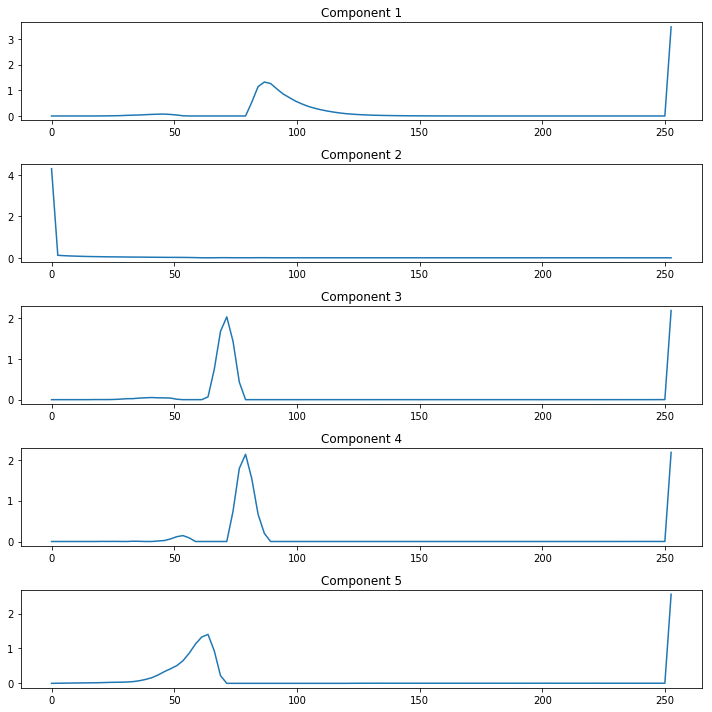

In [40]:
# Visualize the components
plt.figure(figsize = (10,10))
ax1 = plt.subplot(5, 1, 1)
for i in range(5):
    plt.subplot(5, 1, i+1, sharex=ax1)
    plt.plot(bins[:-1],pca.components_[i,:])
    plt.title('Component '+str(i+1))
plt.tight_layout()

In [41]:
# Create an index of decreasing 2ND component coefficient, starting from 'all white' images
# decreasing to regular-color images.
white_idx = X_transformed[:,1].argsort()[::-1]
print(white_idx)

[11852 33072 62521 ... 44601 44600     0]


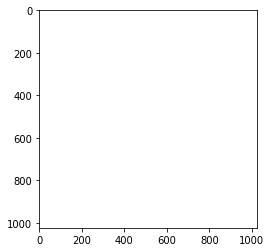

In [42]:
# Make sure topmost image is white
with rasterio.open(hist_df.columns[white_idx[0]], 'r') as r:
    arr = r.read()
      
plt.imshow(np.rollaxis(arr,0,3))

ValueError: num must be 1 <= num <= 100, not 101

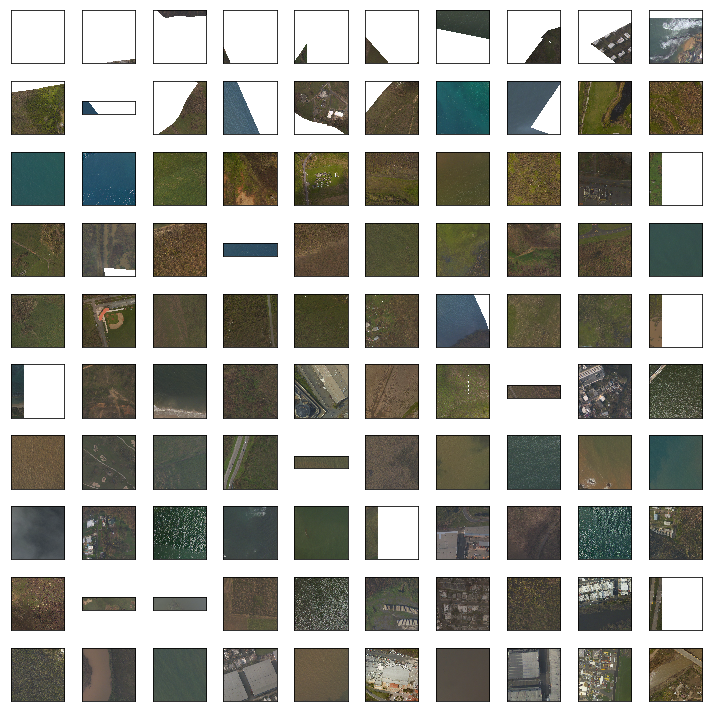

In [43]:
# Visualize the images in order of their "whiteness"
# order: left-to-right, row first
# skip - skips showing every skip'th image
# N - total number of images shown

plt.figure(figsize = (10,10))
#N = hist_df.shape[1]
N = 70000
skip = 600
m = math.floor(math.sqrt(N/skip))
ax1 = plt.subplot(m, m, 1)
for i,j in enumerate(range(0,N,skip)):
    plt.subplot(m, m, i+1, sharex=ax1)
    with rasterio.open(hist_df.columns[white_idx[j]], 'r') as r:
        arr = r.read()
    plt.imshow(np.rollaxis(arr,0,3))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

In [44]:
# Store the filenames order by their "whiteness", up until images are no longer visibly all white.
# Move them out of our dataset.
WHITE_IDX_THRESH = 4800
OUT_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/bad_images/tiles/'

idx_count = 0
with open(OUT_DIR + 'white_img_list.txt', 'w') as f:
    for item in hist_df.columns[white_idx]:
        if idx_count == WHITE_IDX_THRESH:
            break
        f.write("%s\n" % item)
        
        os.system("mv {0} {1}".format(item, OUT_DIR + str(idx_count)))
        
        idx_count += 1